In [1]:
import os
import shutil
from dataset import FaceInTheWild
from model import Discriminator, Generator, DCGAN
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision
import subprocess
from pytorch_fid import fid_score as compute_fid

cpu


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# define the device to use
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

save_dir = os.path.join(os.curdir, 'saved_models')
checkpoint_path = os.path.join(save_dir, 'checkpoint.pth')
trained_model_path = os.path.join(save_dir, 'trained_model.pth')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)


##### PROCEDURE TO GET THE IMAGES #####

NAMES_DIR_PATH = os.path.join(os.curdir, 'dataset/lfw')

In [3]:
def get_people_names():
    """
    This function returns a list of the directories name of each person in the dataset.
    :return:
    """
    return os.listdir(NAMES_DIR_PATH)

def get_images_label(people):
    """
    This function iterates through an array of name's people to access the
    directory that contains the corresponding images and creates a new directory
    containing all the pictures of the people
    :param people: the list of the people names in the dataset.
    :return:
    """
    destination_path = os.path.join(os.curdir, 'images')
    if not os.path.exists(destination_path):
        os.mkdir('images')
    if len(os.listdir(destination_path)) >=2:
        return os.listdir(destination_path)
    for person in people:
        path = os.path.join(NAMES_DIR_PATH, person)
        images = os.listdir(path)
        for image in images:
            image_path = os.path.join(path, image)
            if not os.path.exists(os.path.join(destination_path, image)):
                shutil.copy(image_path, destination_path)
    print('Images parsed correctly.')
    print('Total number of images: {}'.format(len(os.listdir(destination_path))))
    images = os.listdir(destination_path)
    return images


def visualize_sample_image(n_images):
    """
    This function visualize n_images, sampled randomly
    from the dataset
    :param n_images: number of image to print per axis
    :return:
    """
    plt.figure(figsize=(8, 8))
    for idx, image in enumerate(train_dataloader):
        if idx + 1 > n_images**2:
            break
        plt.subplot(n_images, n_images, idx + 1)
        image = image[0].permute(1, 2, 0)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    plt.close()


def split_test_train_images(data, source_path, destination_path, phase):
    if phase == 'train':
        start = 0
        limit = int(len(data)*0.8)
        if os.listdir(destination_path):
            return os.listdir(destination_path)
    elif phase == 'test':
        start = int(len(data)*0.8)
        limit = len(data)
        if os.listdir(destination_path):
            return os.listdir(destination_path)

    for img in data[start:limit]:
        img_path = os.path.join(source_path, img)
        shutil.move(img_path, destination_path)

    return os.listdir(destination_path)

def format_time(start, end):
    """
    Computes the interval time between a start and an end point.
    :param start: starting time
    :param end: ending time
    :return:
    """
    elapsed_time = end - start
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_secs, elapsed_mins

def load_from_checkpoint():
    epoch_idx = 0
    d_loss_history = []
    g_loss_history = []
    d_x_history = []
    d_g_z_history = []
    fid_score_history = []
    if os.path.exists(checkpoint_path):
        loaded_checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
        print('Checkpoint found. Restore from [{}/{}] epoch.'.format(loaded_checkpoint['epoch'], n_epochs))
        epoch_idx = loaded_checkpoint['epoch']
        dcgan.load_state_dict(loaded_checkpoint['dcgan_model'])
        dcgan.discriminator.optim.load_state_dict(loaded_checkpoint['d_optim'])
        dcgan.generator.optim.load_state_dict(loaded_checkpoint['g_optim'])
        d_loss_history = loaded_checkpoint['d_loss_history']
        g_loss_history = loaded_checkpoint['g_loss_history']
        d_x_history = loaded_checkpoint['d_x_history']
        d_g_z_history = loaded_checkpoint['d_g_z_history']
        fid_score_history = loaded_checkpoint['fid_score_history']
        return epoch_idx, d_loss_history, g_loss_history, d_x_history, d_g_z_history, fid_score_history
    else:
        return epoch_idx, d_loss_history, g_loss_history, d_x_history, d_g_z_history, fid_score_history

def save_trained_model(state_dict):
    print('Saving trained model...')
    torch.save(state_dict, trained_model_path)
    print('Model saved correctly.')

In [4]:
# get the names of the people in the dataset.
people_names = get_people_names()
# use those names to access each directory and retrieve the images.
# since we are implementing a GAN model, we don't care about the people's name
# we only want to retrieve the image.
data = get_images_label(people_names)
# create two folder to separate train images from test images
images_path = os.path.join(os.curdir, 'images')
train_path = os.path.join(images_path, 'train')
test_path = os.path.join(images_path, 'test')
if not os.path.exists(train_path):
    os.mkdir(train_path)
if not os.path.exists(test_path):
    os.mkdir(test_path)

train_images = split_test_train_images(data, images_path, train_path, phase='train')
test_images = split_test_train_images(data, images_path, test_path, phase='test')
# create the dataset
train_data = FaceInTheWild(train_images, 'train')
test_data = FaceInTheWild(test_images, 'test')

## building the model
latent_vector = torch.randn((100, 1))
input_size = latent_vector.shape[0]
generator = Generator(input_size).to(device)
discriminator = Discriminator().to(device)
dcgan = DCGAN(generator, discriminator, input_size).to(device)

# hyperparameters
batch_size = 64
optim_params = {'lr': 0.0002, 'betas': (0.5, 0.999)}
n_epochs = 10
# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

real_img = 1
fake_img = 0

...Initialize weights from N(0, 0.02)...
Weights initialized.
...Initialize weights from N(0, 0.02)...
Weights initialized.


In [5]:
def evaluate():
    """
    Compute the FID score. We use the open-source library pytorch-fid
    :return:
    """
    dcgan.discriminator.eval()
    dcgan.generator.eval()
    generated_path = os.path.join(images_path, 'generated')
    test_path = os.path.join(images_path, 'test')
    if os.path.exists(generated_path):
        shutil.rmtree(generated_path)
    os.mkdir(generated_path)
    # feedforward pass all the test images through the generator
    for idx, _ in enumerate(test_dataloader):
        noise = torch.randn((1, input_size, 1, 1), dtype=torch.float).to(device)
        gen_img = dcgan.generator(noise)
        gen_img = gen_img.reshape(3, 64, 64)
        gen_img = (gen_img * 0.5) + 0.5
        gen_img = torchvision.transforms.ToPILImage(mode='RGB')(gen_img)
        gen_img.save(generated_path+'/gen_'+str(idx)+'.jpg')
    fid_score = compute_fid.calculate_fid_given_paths([generated_path, test_path], 50, device, 2048)
    return fid_score


In [6]:
n_epochs = 2000
print_every = 100
def train_loop():
    epoch_idx, d_loss_history, g_loss_history, d_x_history, d_g_z_history, fid_score_history = load_from_checkpoint()
    for epoch in range(epoch_idx+1, n_epochs+1):
        d_loss_running = []
        g_loss_running = []
        d_x_running = []
        d_g_z_running = []
        start_time = time.time()
        for idx, batch in enumerate(train_dataloader):
            # TRAIN PROCEDURE
            # get batch of real images
            # each image has a shape of [NxCxHxW] --> [64x3x64x64]
            d_loss, g_loss, D_X, D_G_z = dcgan(batch)
            # store losses
            d_loss_running.append(d_loss)
            g_loss_running.append(g_loss)
            d_x_running.append(D_X)
            d_g_z_running.append(D_G_z)

        d_loss_history.append(np.mean(d_loss_running).item())
        g_loss_history.append(np.mean(g_loss_running).item())
        d_x_history.append(np.mean(d_x_running).item())
        d_g_z_history.append(np.mean(d_g_z_running).item())
        if epoch+1 % print_every == 0:
            # visualize a sample of generated images once every n epoch
            fid_score = evaluate()
            fid_score_history.append(fid_score)
            gen_images = dcgan.apply_knowledge()
            dcgan.visualize_sample(gen_images)
            checkpoint = {'epoch': epoch,
                        'dcgan_model': dcgan.state_dict(),
                        'd_optim': dcgan.discriminator.optim.state_dict(),
                        'g_optim': dcgan.generator.optim.state_dict(),
                        'd_loss_history': d_loss_history,
                        'g_loss_history': g_loss_history,
                        'd_x_history': d_x_history,
                        'd_g_z_history': d_g_z_history,
                        'fid_score_history': fid_score_history}
            print('Checkpoint [%.d/%.d], D_Loss: %.4f, G_Loss: %.4f, D(x): %.4f, D(G(z)): %.4f, FID: %.4f' % (epoch,
                                                                                                     n_epochs,
                                                                                                     d_loss_running[-1],
                                                                                                     g_loss_running[-1],
                                                                                                     d_x_history[-1],
                                                                                                     d_g_z_history[-1],
                                                                                                     fid_score_history[-1]),
              end='| ')
            torch.save(checkpoint, checkpoint_path)
        end_time = time.time()
        elapsed_sec, elapsed_min = format_time(start_time, end_time)
        print('Epoch [{}]/[{}], eta: {}m {}s'.format(epoch, n_epochs, elapsed_min, elapsed_sec))
    print('Training Complete.')
    save_trained_model(dcgan.state_dict())

In [7]:
train_loop()

Checkpoint found. Restore from [2000/2000] epoch.
Training Complete.
Saving trained model...
Model saved correctly.


In [8]:
epoch_idx, d_loss_history, g_loss_history, d_x_history, d_g_z_history, fid_score_history = load_from_checkpoint()

Checkpoint found. Restore from [2000/2000] epoch.


In [9]:
def plot_g_vs_d_loss(d_history, g_history):
    plt.figure(figsize=(10, 5))
    plt.title('Generator Loss vs Discriminator Loss')
    plt.plot(d_history, label='Discriminator')
    plt.plot(g_history, label='Generator')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [10]:
def plot_gx_vs_dgz(dx_history, dgz_history):
    plt.figure(figsize=(10, 5))
    plt.title("G(x) vs D(G(z))")
    plt.plot(dx_history, label='G(x)')
    plt.plot(dgz_history, label='D(G(z))')
    plt.xlabel("Epochs")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

In [11]:
def plot_fid(fid_history):
    plt.figure(figsize=(10, 5))
    plt.title('FID score History')
    plt.plot(fid_history, label='FID-Score')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

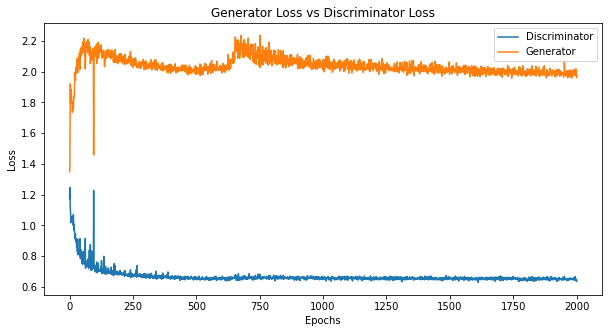

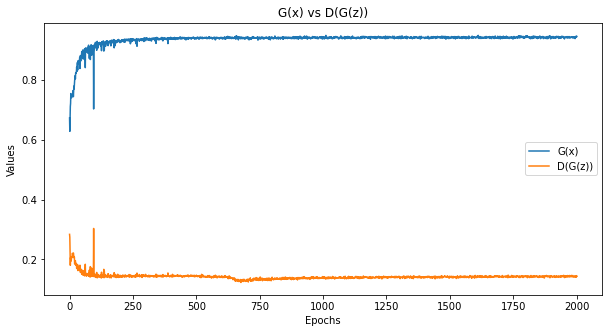

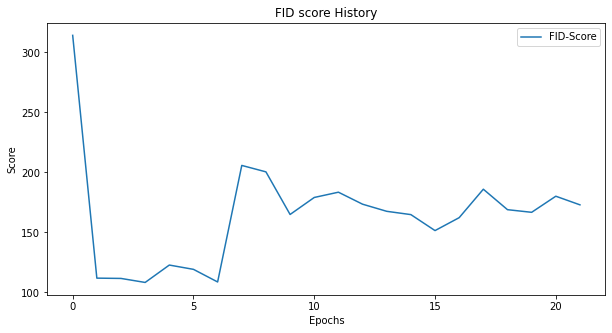

In [12]:
plot_g_vs_d_loss(d_loss_history, g_loss_history)
plot_gx_vs_dgz(d_x_history, d_g_z_history)
plot_fid(fid_score_history)

In [13]:
print("%.2f" % (np.mean(fid_score_history)))

164.80


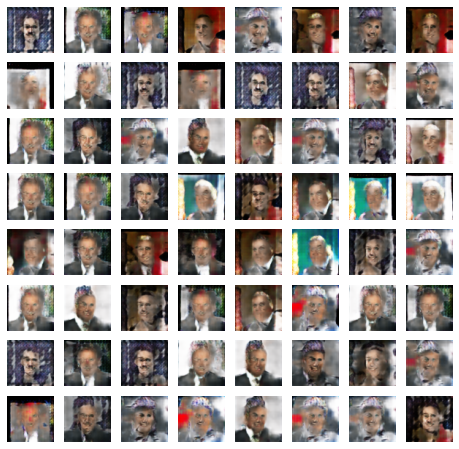

In [14]:
gen_images = dcgan.apply_knowledge()
dcgan.visualize_sample(gen_images)